<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex05/Marcus_Vinicius_Borela_de_Castro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
nome = 'Marcus Vinícius Borela de CAstro'

print(f'Meu nome é {nome}')

Meu nome é Marcus Vinícius Borela de CAstro


Este exercicío consiste em treinar no MNIST um modelo de duas camadas, sendo a primeira uma camada convolucional e a segunda uma camada linear de classificação.

Não podemos usar as funções torch.nn.Conv{1,2,3}d

## Importação das bibliotecas

In [124]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torchvision.datasets import MNIST

## Fixando as seeds

In [125]:
def inicializa_seed(num_semente:int=123):
  """
  É recomendado reiniciar as seeds antes de inicializar o modelo, pois assim
  garantimos que os pesos vao ser sempre os mesmos.
  fontes de apoio: 
      http://nlp.seas.harvard.edu/2018/04/03/attention.html
      https://github.com/CyberZHG/torch-multi-head-attention/blob/master/torch_multi_head_attention/multi_head_attention.py#L15
  """
  random.seed(num_semente)
  np.random.seed(num_semente)
  torch.manual_seed(num_semente)
  #torch.cuda.manual_seed(num_semente)
  #Cuda algorithms
  #torch.backends.cudnn.deterministic = True 

In [126]:
inicializa_seed(123)

## Define pesos iniciais

In [127]:
in_channels = 1
out_channels = 2
kernel_size = 5
stride = 3

# Input image size
height_in = 28  
width_in = 28

# Image size after the first convolutional layer.
height_out = (height_in - kernel_size - 1) // stride + 1
width_out = (width_in - kernel_size - 1) // stride + 1


initial_conv_weight = torch.FloatTensor(out_channels, in_channels, kernel_size, kernel_size).uniform_(-0.01, 0.01)
initial_conv_bias = torch.FloatTensor(out_channels,).uniform_(-0.01, 0.01)

initial_classification_weight = torch.FloatTensor(10, out_channels * height_out * width_out).uniform_(-0.01, 0.01)
initial_classification_bias = torch.FloatTensor(10,).uniform_(-0.01, 0.01)

In [128]:
print(f" height_out {height_out}, width_out {width_out}")

 height_out 8, width_out 8


## Dataset e dataloader

### Definição do tamanho do minibatch

In [129]:
batch_size = 50

### Carregamento, criação dataset e do dataloader

In [130]:
dataset_dir = '../data/'

dataset_train_full = MNIST(dataset_dir, train=True, download=True,
                           transform=torchvision.transforms.ToTensor())
print(dataset_train_full.data.shape)
print(dataset_train_full.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


### Usando apenas 1000 amostras do MNIST

Neste exercício utilizaremos 1000 amostras de treinamento.

In [131]:
indices = torch.randperm(len(dataset_train_full))[:1000]
dataset_train = torch.utils.data.Subset(dataset_train_full, indices)

## Define os pesos iniciais

In [132]:
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

In [133]:
print('Número de minibatches de trenamento:', len(loader_train))


Número de minibatches de trenamento: 20


In [134]:
x_train, y_train = next(iter(loader_train))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))


Dimensões dos dados de um minibatch: torch.Size([50, 1, 28, 28])
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


In [135]:
x_train.shape, y_train.shape

(torch.Size([50, 1, 28, 28]), torch.Size([50]))

In [136]:
x_train[0, 0, 0, ] # 1a linha da 1a amostra

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])

In [137]:
x_train[0, 0,] # 28 linhas da 1a amostra

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [138]:
x_train.shape[1] # canais

1

## Camada Convolucional

In [139]:
torch.zeros((4,1,4,5),  dtype=torch.float, requires_grad=True)

tensor([[[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]]], requires_grad=True)

In [140]:
saida = torch.empty((4,1,4,5),  dtype=torch.float, requires_grad=True)

In [141]:
saida.shape

torch.Size([4, 1, 4, 5])

In [142]:
saida[0,0,0]

tensor([1.0943e-35, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<SelectBackward0>)

In [143]:
# torch.cat((saida[0,0,0], torch.tensor([[12]])), dim=-1)

In [144]:
# saida

In [162]:
class MyConv2d(torch.nn.Module):
  def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int, verbose:bool = False):
    super(MyConv2d, self).__init__()

    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size  # The same for height and width.
    self.stride = stride  # The same for height and width.
    self.weight = torch.nn.Parameter(torch.FloatTensor(out_channels, in_channels, kernel_size, kernel_size).uniform_(-0.01, 0.01))
    self.bias = torch.nn.Parameter(torch.FloatTensor(out_channels,).uniform_(-0.01, 0.01))
    self.verbose = verbose
    if self.verbose:
      print(f"Inicializado MyConv2d")
      print(f"in_channels: {self.in_channels} ")
      print(f"out_channels: {self.out_channels} ")
      print(f"kernel_size: {self.kernel_size} ")
      print(f"stride: {self.stride} ")
      print(f"weight.shape: {self.weight.shape} ")
      print(f"weight: {self.weight} ")
      print(f"bias.shape: {self.bias.shape} ")
      print(f"bias: {self.bias} ")

  def forward(self, x):
    assert x.dim() == 4, f'x must have 4 dimensions, not {x.shape}'
    assert x.shape[1] == 1, f'x must have only 1 channel, not {x.shape[1]}' # Num_canais sempre 1 (mnist, preto/branco)

    # print(f"kernel.shape: {self.weight.shape}, kernel: {self.weight}")
    # Escreva seu código aqui.
    # versão com for nas dimensões de X
    num_amostras = x.shape[0]
    num_linhas_entrada = x.shape[2]
    num_colunas_entrada = x.shape[3]
    num_linhas_saida = (num_linhas_entrada - self.kernel_size) // self.stride + 1
    num_colunas_saida = (num_colunas_entrada - self.kernel_size) // self.stride + 1
    saida = torch.zeros((num_amostras,self.out_channels,num_linhas_saida,num_colunas_saida), dtype=torch.float, requires_grad=False)        
    if self.verbose:
      print(f" num_amostras: {num_amostras}, self.out_channels: {self.out_channels}, num_linhas_entrada: {num_linhas_entrada}, num_colunas_entrada: {num_colunas_entrada}, num_linhas_saida: {num_linhas_saida}, num_colunas_saida: {num_colunas_saida}")
      print(f"saida.shape: {saida.shape}")
    for ndx_amostra in range(num_amostras):
      if self.verbose:
        print(f"\nndx_amostra: {ndx_amostra}")
      # for ndx_out_channels in range(self.out_channels):
      #   print(f"\nndx_out_channels: {ndx_out_channels}")
      for ndx_in_channels in range(self.in_channels):
        if self.verbose:
          print(f"\nndx_in_channels: {ndx_in_channels}")
        ndx_linhas_entrada = 0
        for ndx_linhas_saida in range(num_linhas_saida):
          ndx_colunas_entrada = 0
          for ndx_colunas_saida in range(num_colunas_saida):
            produto = torch.mul(x[ndx_amostra, ndx_in_channels, ndx_linhas_entrada:ndx_linhas_entrada+self.kernel_size, ndx_colunas_entrada:ndx_colunas_entrada+self.kernel_size], self.weight)
            soma = torch.sum(produto, dim=(2,3), keepdim=True )
            valor_soma = soma.squeeze()
            if self.verbose:
              print(f"\nndx_linhas_saida, ndx_colunas_saida: {ndx_linhas_saida}, {ndx_colunas_saida}")
              print(f" alvo do kernel em x: x[{ndx_amostra},{ndx_in_channels},{ndx_linhas_entrada}:{ndx_linhas_entrada+self.kernel_size}, {ndx_colunas_entrada}:{ndx_colunas_entrada+self.kernel_size}]")
              print(f" \n {x[ndx_amostra, ndx_in_channels, ndx_linhas_entrada:ndx_linhas_entrada+self.kernel_size, ndx_colunas_entrada:ndx_colunas_entrada+self.kernel_size]}")
              print(f" produto: {produto}")
              print(f" soma: {soma}")
              print(f" valor_soma: {valor_soma}")
            # saida = torch.cat((saida, soma))
            if self.out_channels > 1:  # soma é um com dimensões, como em torch.tensor([[[[ 46.]], [[134.]]]])
              for ndx_out_channels in range(self.out_channels):
                saida[ndx_amostra, ndx_out_channels, ndx_linhas_saida, ndx_colunas_saida] += valor_soma[ndx_out_channels]
                if self.verbose:
                  print(f" somado na saída em [{ndx_amostra}, {ndx_out_channels}, {ndx_linhas_saida}, {ndx_colunas_saida}] = {saida[ndx_amostra, ndx_out_channels, ndx_linhas_saida, ndx_colunas_saida]}")
            else: # soma é um tensor escalar, como em tensor(34.)
                saida[ndx_amostra, 0, ndx_linhas_saida, ndx_colunas_saida] += valor_soma
                if self.verbose:
                  print(f" somado na saída em [{ndx_amostra}, 0, {ndx_linhas_saida}, {ndx_colunas_saida}] = {saida[ndx_amostra, 0, ndx_linhas_saida, ndx_colunas_saida]}")
            ndx_colunas_entrada += self.stride
          ndx_linhas_entrada += self.stride
    if self.verbose:
      print(f" saida: {saida}")
    # somando bias
    for ndx_amostra in range(num_amostras):
      if self.verbose:
        print(f"\nndx_amostra: {ndx_amostra}")
      for ndx_out_channels in range(self.out_channels):
        saida[ndx_amostra, ndx_out_channels] += self.bias[ndx_out_channels]
    if self.verbose:
      print(f" saida apos somar bias: {saida}")
    # versão com for no kernel

    return saida

## Compare se sua implementação está igual à do pytorch usando um exemplo simples

In [146]:
in_channels_dummy = 1
out_channels_dummy = 1
kernel_size_dummy = 2
stride_dummy = 1
x = torch.arange(30).float().reshape(1, 1, 5, 6)

In [147]:
print(x)

tensor([[[[ 0.,  1.,  2.,  3.,  4.,  5.],
          [ 6.,  7.,  8.,  9., 10., 11.],
          [12., 13., 14., 15., 16., 17.],
          [18., 19., 20., 21., 22., 23.],
          [24., 25., 26., 27., 28., 29.]]]])


In [148]:

conv_layer = MyConv2d( in_channels=in_channels_dummy,out_channels=out_channels_dummy, kernel_size=kernel_size_dummy, stride=stride_dummy, verbose=True)

# Usa os mesmos pesos para minha implementação e a do pytorch
initial_weights_dummy = torch.arange(in_channels_dummy * out_channels_dummy * kernel_size_dummy * kernel_size_dummy).float()
initial_weights_dummy = initial_weights_dummy.reshape(in_channels_dummy, out_channels_dummy, kernel_size_dummy, kernel_size_dummy)
initial_bias_dummy = torch.arange(out_channels_dummy,).float()

conv_layer.weight.data = initial_weights_dummy
conv_layer.bias.data = initial_bias_dummy

out = conv_layer(x)


Inicializado MyConv2d
in_channels: 1 
out_channels: 1 
kernel_size: 2 
stride: 1 
weight.shape: torch.Size([1, 1, 2, 2]) 
weight: Parameter containing:
tensor([[[[-0.0086, -0.0075],
          [ 0.0077,  0.0033]]]], requires_grad=True) 
bias.shape: torch.Size([1]) 
bias: Parameter containing:
tensor([0.0023], requires_grad=True) 
 num_amostras: 1, self.out_channels: 1, num_linhas_entrada: 5, num_colunas_entrada: 6, num_linhas_saida: 4, num_colunas_saida: 5
saida.shape: torch.Size([1, 1, 4, 5])

ndx_amostra: 0

ndx_in_channels: 0

ndx_linhas_saida, ndx_colunas_saida: 0, 0
 alvo do kernel em x: x[0,0,0:2, 0:2]
 
 tensor([[0., 1.],
        [6., 7.]])
 produto: tensor([[[[ 0.,  1.],
          [12., 21.]]]], grad_fn=<MulBackward0>)
 soma: tensor([[[[34.]]]], grad_fn=<SumBackward1>)
 valor_soma: 34.0
 somado na saída em [0, 0, 0, 0] = 34.0

ndx_linhas_saida, ndx_colunas_saida: 0, 1
 alvo do kernel em x: x[0,0,0:2, 1:3]
 
 tensor([[1., 2.],
        [7., 8.]])
 produto: tensor([[[[ 0.,  2.],
  

In [149]:
pytorch_conv_layer = torch.nn.Conv2d(out_channels=out_channels_dummy, in_channels=in_channels_dummy, kernel_size=kernel_size_dummy, stride=stride_dummy, padding=0)
pytorch_conv_layer.load_state_dict(dict(weight=initial_weights_dummy, bias=initial_bias_dummy))
target_out = pytorch_conv_layer(x)

In [150]:
target_out.shape

torch.Size([1, 1, 4, 5])

In [151]:
assert torch.allclose(out, target_out, atol=1e-6)

## Compare se sua implementação está igual à do pytorch usando um exemplo aleatório

In [152]:
x = torch.rand(2, in_channels, height_in, width_in)
print(f"x.shape: {x.shape}, x:{x}")

x.shape: torch.Size([2, 1, 28, 28]), x:tensor([[[[0.5455, 0.3101, 0.0920,  ..., 0.9578, 0.6826, 0.8853],
          [0.5961, 0.6101, 0.5993,  ..., 0.4560, 0.5637, 0.3034],
          [0.4390, 0.1588, 0.3511,  ..., 0.1117, 0.4930, 0.1629],
          ...,
          [0.6152, 0.2852, 0.8054,  ..., 0.3297, 0.2332, 0.6874],
          [0.5257, 0.5642, 0.3265,  ..., 0.8634, 0.6886, 0.6107],
          [0.4996, 0.8803, 0.2029,  ..., 0.8815, 0.3183, 0.3953]]],


        [[[0.6082, 0.3287, 0.8834,  ..., 0.1798, 0.4401, 0.8556],
          [0.8919, 0.6539, 0.3631,  ..., 0.9050, 0.6740, 0.4383],
          [0.4295, 0.3832, 0.0433,  ..., 0.3678, 0.3228, 0.4308],
          ...,
          [0.9189, 0.8832, 0.5742,  ..., 0.8215, 0.8630, 0.0347],
          [0.5718, 0.9940, 0.8956,  ..., 0.3014, 0.6284, 0.8481],
          [0.1658, 0.4905, 0.1542,  ..., 0.2615, 0.4488, 0.7076]]]])


In [153]:
conv_layer = MyConv2d(out_channels=out_channels, in_channels=in_channels, kernel_size=kernel_size, stride=stride, verbose=True)
conv_layer.weight.data = initial_conv_weight
conv_layer.bias.data = initial_conv_bias
print(f"conv_layer.weight.data.shape: {conv_layer.weight.data.shape}, conv_layer.bias.data.shape: {conv_layer.bias.data.shape}")
print(f"conv_layer.weight.data: {conv_layer.weight.data}, conv_layer.bias.data: {conv_layer.bias.data}")

Inicializado MyConv2d
in_channels: 1 
out_channels: 2 
kernel_size: 5 
stride: 3 
weight.shape: torch.Size([2, 1, 5, 5]) 
weight: Parameter containing:
tensor([[[[ 0.0008,  0.0056, -0.0072, -0.0082,  0.0032],
          [ 0.0022,  0.0017, -0.0063,  0.0087, -0.0062],
          [ 0.0099,  0.0029, -0.0072,  0.0052,  0.0080],
          [-0.0063,  0.0090,  0.0075,  0.0028, -0.0072],
          [-0.0068, -0.0099, -0.0066,  0.0015,  0.0053]]],


        [[[ 0.0058, -0.0063, -0.0015,  0.0055,  0.0050],
          [ 0.0091,  0.0066,  0.0017,  0.0025, -0.0018],
          [-0.0048, -0.0093, -0.0090, -0.0052, -0.0045],
          [-0.0096, -0.0060,  0.0076,  0.0046, -0.0072],
          [ 0.0017,  0.0064, -0.0099, -0.0048,  0.0045]]]], requires_grad=True) 
bias.shape: torch.Size([2]) 
bias: Parameter containing:
tensor([-0.0091, -0.0073], requires_grad=True) 
conv_layer.weight.data.shape: torch.Size([2, 1, 5, 5]), conv_layer.bias.data.shape: torch.Size([2])
conv_layer.weight.data: tensor([[[[-0.0041,  

In [154]:
out = conv_layer(x)

 num_amostras: 2, self.out_channels: 2, num_linhas_entrada: 28, num_colunas_entrada: 28, num_linhas_saida: 8, num_colunas_saida: 8
saida.shape: torch.Size([2, 2, 8, 8])

ndx_amostra: 0

ndx_in_channels: 0

ndx_linhas_saida, ndx_colunas_saida: 0, 0
 alvo do kernel em x: x[0,0,0:5, 0:5]
 
 tensor([[0.5455, 0.3101, 0.0920, 0.7078, 0.7724],
        [0.5961, 0.6101, 0.5993, 0.1743, 0.6640],
        [0.4390, 0.1588, 0.3511, 0.6755, 0.4505],
        [0.9398, 0.6030, 0.0968, 0.8615, 0.7700],
        [0.6040, 0.6931, 0.0116, 0.7928, 0.1653]])
 produto: tensor([[[[-2.2242e-03,  1.0272e-04, -4.5687e-04,  2.6693e-03, -6.5817e-03],
          [ 4.3699e-03, -4.4341e-03, -4.7650e-03, -1.1013e-03,  3.0073e-03],
          [-1.6220e-03,  5.9416e-04, -2.9797e-03, -4.0984e-03, -1.6540e-03],
          [-1.8468e-03, -4.6004e-03,  6.3367e-04, -2.0317e-03,  2.4717e-03],
          [ 4.2710e-03,  1.2913e-03,  3.1844e-05,  7.6530e-03, -7.4545e-04]]],


        [[[ 1.7277e-03, -1.3796e-03,  6.5740e-04,  5.6531e-03

In [155]:
out.shape

torch.Size([2, 2, 8, 8])

In [156]:
# Usa os mesmos pesos para minha implementação e a do pytorch
pytorch_conv_layer = torch.nn.Conv2d( in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=0)
pytorch_conv_layer.load_state_dict(dict(weight=initial_conv_weight, bias=initial_conv_bias))

target_out = pytorch_conv_layer(x)

In [157]:
target_out.shape

torch.Size([2, 2, 8, 8])

In [158]:
assert torch.allclose(out, target_out, atol=1e-6)

## Modelo

In [164]:
class Net(torch.nn.Module):
    def __init__(self, height_in: int, width_in: int, in_channels: int, out_channels: int, kernel_size: int, stride: int):
        super(Net, self).__init__()
        self.conv_layer = MyConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)
   
        height_out = (height_in - kernel_size) // stride + 1
        width_out = (width_in - kernel_size) // stride + 1
        self.classification_layer = torch.nn.Linear(out_channels * height_out * width_out, 10)

    def forward(self, x):
        hidden = self.conv_layer(x)
        hidden = torch.nn.functional.relu(hidden)
        hidden = hidden.reshape(x.shape[0], -1)
        logits = self.classification_layer(hidden)
        return logits

## Treinamento

### Definição dos hiperparâmetros

In [165]:
n_epochs = 50
lr = 0.1

### Laço de treinamento

In [166]:
model = Net(height_in=height_in, width_in=width_in, in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)

# Usa pesos iniciais pré-difinidos
model.classification_layer.load_state_dict(dict(weight=initial_classification_weight, bias=initial_classification_bias))
model.conv_layer.weight.data = initial_conv_weight
model.conv_layer.bias.data = initial_conv_bias

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)

epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0
for i in range(n_epochs):
    for x_train, y_train in loader_train:
        # predict da rede
        outputs = model(x_train)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(dataset_train))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')


Epoch: 0/49 Loss: 0.9586364030838013
Epoch: 1/49 Loss: 0.565815269947052
Epoch: 2/49 Loss: 0.4770318567752838
Epoch: 3/49 Loss: 0.42453765869140625
Epoch: 4/49 Loss: 0.38708603382110596
Epoch: 5/49 Loss: 0.35843756794929504
Epoch: 6/49 Loss: 0.336288183927536
Epoch: 7/49 Loss: 0.31845659017562866
Epoch: 8/49 Loss: 0.3037392497062683
Epoch: 9/49 Loss: 0.2910858988761902
Epoch: 10/49 Loss: 0.2799944579601288
Epoch: 11/49 Loss: 0.270416259765625
Epoch: 12/49 Loss: 0.2619065046310425
Epoch: 13/49 Loss: 0.25361135601997375
Epoch: 14/49 Loss: 0.24582411348819733
Epoch: 15/49 Loss: 0.23841428756713867
Epoch: 16/49 Loss: 0.23117700219154358
Epoch: 17/49 Loss: 0.2241152971982956
Epoch: 18/49 Loss: 0.2175927609205246
Epoch: 19/49 Loss: 0.21121275424957275
Epoch: 20/49 Loss: 0.2050437331199646
Epoch: 21/49 Loss: 0.19928722083568573
Epoch: 22/49 Loss: 0.1938953399658203
Epoch: 23/49 Loss: 0.1882905215024948
Epoch: 24/49 Loss: 0.1828724443912506
Epoch: 25/49 Loss: 0.1776149421930313
Epoch: 26/49 Lo

### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

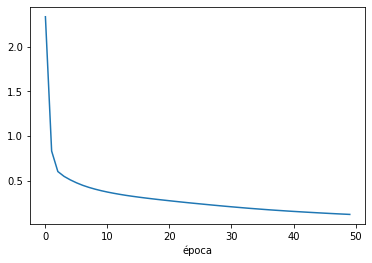

In [167]:
n_batches_train = len(loader_train)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

In [168]:
loss_epoch_end

[0.9586364030838013,
 0.565815269947052,
 0.4770318567752838,
 0.42453765869140625,
 0.38708603382110596,
 0.35843756794929504,
 0.336288183927536,
 0.31845659017562866,
 0.3037392497062683,
 0.2910858988761902,
 0.2799944579601288,
 0.270416259765625,
 0.2619065046310425,
 0.25361135601997375,
 0.24582411348819733,
 0.23841428756713867,
 0.23117700219154358,
 0.2241152971982956,
 0.2175927609205246,
 0.21121275424957275,
 0.2050437331199646,
 0.19928722083568573,
 0.1938953399658203,
 0.1882905215024948,
 0.1828724443912506,
 0.1776149421930313,
 0.17248651385307312,
 0.16733810305595398,
 0.16254152357578278,
 0.15758882462978363,
 0.1527339220046997,
 0.14789022505283356,
 0.14303667843341827,
 0.1380799561738968,
 0.13330009579658508,
 0.12855049967765808,
 0.12378916144371033,
 0.119150809943676,
 0.11474869400262833,
 0.110462486743927,
 0.10636704415082932,
 0.10245434939861298,
 0.09870947152376175,
 0.09508325904607773,
 0.09160909056663513,
 0.08813302963972092,
 0.0847537815

In [ ]:
# Assert do histórico de losses
target_loss_epoch_end = np.array([
    2.303267478942871,
    2.227701187133789,
    1.0923893451690674,
    0.5867354869842529,
    0.5144089460372925,
    0.45026642084121704,
    0.4075140357017517,
    0.37713879346847534,
    0.3534485101699829,
    0.3341451585292816,
    0.3181140422821045,
    0.30457887053489685,
    0.29283496737480164,
    0.2827608287334442,
    0.2738332152366638,
    0.2657742500305176,
    0.2583288848400116,
    0.25117507576942444,
    0.24439716339111328,
    0.23789969086647034,
    0.23167723417282104,
    0.22562651336193085,
    0.21984536945819855,
    0.2142913043498993,
    0.20894232392311096,
    0.203872948884964,
    0.19903430342674255,
    0.19439971446990967,
    0.18994088470935822,
    0.18563991785049438,
    0.18147490918636322,
    0.17744913697242737,
    0.17347246408462524,
    0.16947467625141144,
    0.16547319293022156,
    0.16150487959384918,
    0.1574639081954956,
    0.1534043848514557,
    0.14926929771900177,
    0.1452063024044037,
    0.1412365883588791,
    0.13712672889232635,
    0.1331038922071457,
    0.1291467249393463,
    0.1251506358385086,
    0.12116757035255432,
    0.11731722950935364,
    0.11364627629518509,
    0.11001908034086227,
    0.10655981302261353])

assert np.allclose(np.array(loss_epoch_end), target_loss_epoch_end, atol=1e-6)

## Rascunho

In [66]:
in_channels_dummy = 1
out_channels_dummy = 2
kernel_size_dummy = 3
stride_dummy = 2
num_amostras_dummy = 1
x = torch.arange(30).float().reshape(num_amostras_dummy, 1, 5, 6)

In [67]:
print(x)

tensor([[[[ 0.,  1.,  2.,  3.,  4.,  5.],
          [ 6.,  7.,  8.,  9., 10., 11.],
          [12., 13., 14., 15., 16., 17.],
          [18., 19., 20., 21., 22., 23.],
          [24., 25., 26., 27., 28., 29.]]]])


In [ ]:
# falta stride e tratar out_channels > 1

In [69]:

conv_layer = MyConv2d( in_channels=in_channels_dummy,out_channels=out_channels_dummy, kernel_size=kernel_size_dummy, stride=stride_dummy, verbose=True)

# Usa os mesmos pesos para minha implementação e a do pytorch
initial_weights_dummy = torch.arange(in_channels_dummy * out_channels_dummy * kernel_size_dummy * kernel_size_dummy).float()
initial_weights_dummy = initial_weights_dummy.reshape(out_channels_dummy, in_channels_dummy,  kernel_size_dummy, kernel_size_dummy)
initial_bias_dummy = torch.arange(out_channels_dummy,).float()
print(f"initial_bias_dummy.shape {initial_bias_dummy.shape}, initial_weights_dummy.shape {initial_weights_dummy.shape}")

Inicializado MyConv2d
in_channels: 1 
out_channels: 2 
kernel_size: 3 
stride: 2 
weight.shape: torch.Size([2, 1, 3, 3]) 
weight: Parameter containing:
tensor([[[[-0.0082, -0.0041, -0.0035],
          [ 0.0023, -0.0072,  0.0030],
          [-0.0095,  0.0072, -0.0016]]],


        [[[-0.0069, -0.0036,  0.0015],
          [ 0.0053, -0.0033, -0.0039],
          [ 0.0075,  0.0062, -0.0042]]]], requires_grad=True) 
bias.shape: torch.Size([2]) 
bias: Parameter containing:
tensor([ 0.0033, -0.0044], requires_grad=True) 
initial_bias_dummy.shape torch.Size([2]), initial_weights_dummy.shape torch.Size([2, 1, 3, 3])


In [70]:
conv_layer.weight.data = initial_weights_dummy
conv_layer.bias.data = initial_bias_dummy
print(f"conv_layer.weight.data: {conv_layer.weight.data}")
print(f"conv_layer.bias.data: {conv_layer.bias.data}")


conv_layer.weight.data: tensor([[[[ 0.,  1.,  2.],
          [ 3.,  4.,  5.],
          [ 6.,  7.,  8.]]],


        [[[ 9., 10., 11.],
          [12., 13., 14.],
          [15., 16., 17.]]]])
conv_layer.bias.data: tensor([0., 1.])


In [71]:
print(x)

tensor([[[[ 0.,  1.,  2.,  3.,  4.,  5.],
          [ 6.,  7.,  8.,  9., 10., 11.],
          [12., 13., 14., 15., 16., 17.],
          [18., 19., 20., 21., 22., 23.],
          [24., 25., 26., 27., 28., 29.]]]])


In [72]:
out = conv_layer(x)


 num_amostras: 1, self.out_channels: 2, num_linhas_entrada: 5, num_colunas_entrada: 6, num_linhas_saida: 2, num_colunas_saida: 2
saida.shape: torch.Size([1, 2, 2, 2])

ndx_amostra: 0

ndx_in_channels: 0

ndx_linhas_saida, ndx_colunas_saida: 0, 0
 alvo do kernel em x: x[0,0,0:3, 0:3]
 
 tensor([[ 0.,  1.,  2.],
        [ 6.,  7.,  8.],
        [12., 13., 14.]])
 produto: tensor([[[[  0.,   1.,   4.],
          [ 18.,  28.,  40.],
          [ 72.,  91., 112.]]],


        [[[  0.,  10.,  22.],
          [ 72.,  91., 112.],
          [180., 208., 238.]]]], grad_fn=<MulBackward0>)
 soma: tensor([[[[366.]]],


        [[[933.]]]], grad_fn=<SumBackward1>)
 valor_soma: tensor([366., 933.], grad_fn=<SqueezeBackward0>)
 somado na saída em [0, 0, 0, 0] = 366.0
 somado na saída em [0, 1, 0, 0] = 933.0

ndx_linhas_saida, ndx_colunas_saida: 0, 1
 alvo do kernel em x: x[0,0,0:3, 2:5]
 
 tensor([[ 2.,  3.,  4.],
        [ 8.,  9., 10.],
        [14., 15., 16.]])
 produto: tensor([[[[  0.,   3.,   8.]

In [ ]:
temp = torch.tensor([[[[34.]]]])

In [ ]:
temp.squeeze()

tensor(34.)

In [ ]:
temp.squeeze().shape

torch.Size([])

In [ ]:
temp.squeeze().reshape(1,)

tensor([34.])

In [ ]:
temp.view(1,-1)

tensor([[34.]])

In [ ]:
temp = torch.tensor([[[[ 46.]], [[134.]]]])

In [ ]:
temp.squeeze()

tensor([ 46., 134.])

In [ ]:
temp.squeeze().shape

torch.Size([2])

In [ ]:
temp.squeeze().reshape(2,)

tensor([ 46., 134.])

In [ ]:
temp.squeeze().shape


torch.Size([2])